## Workbook 2 - Training a Feed-Forward Neural Network using UrbanSound8K audio data 

This loads the features we extracted using librosa (see workbook 1), and uses them to train a Feed-Forward Network, a simple deep neural net with a few hidden layers, and then predict the class of a set of previously unheard audio files.

In [11]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

This code below loads previously computed numpy features for each of the 10 folds, we'll use the first 8 for training, and keep one back for validation and one for testing.

In [12]:
data_dir = "data/us8k-np-ffn"

def add_folds():
    subsequent_fold = False
    for k in range(1,9):
        fold_name = 'fold' + str(k)
        print "\nAdding " + fold_name
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print "New Features: ", loaded_features.shape

        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
        
    return features, labels

train_x, train_y = add_folds()

# use a fold for validation
valid_fold_name = 'fold9'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
valid_x = np.load(feature_file)
valid_y = np.load(labels_file) 

# and a fold for testing
test_fold_name = 'fold10'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
test_x = np.load(feature_file)
test_y = np.load(labels_file)

print "\nTraining Set Features: ", train_x.shape
print "Training Set Labels: ", train_y.shape
print "Test Set Features:  ", test_x.shape
print "Test Set Labels:  ", test_y.shape



Adding fold1
New Features:  (873, 193)

Adding fold2
New Features:  (888, 193)

Adding fold3
New Features:  (925, 193)

Adding fold4
New Features:  (990, 193)

Adding fold5
New Features:  (936, 193)

Adding fold6
New Features:  (823, 193)

Adding fold7
New Features:  (838, 193)

Adding fold8
New Features:  (806, 193)

Training Set Features:  (7079, 193)
Training Set Labels:  (7079, 10)
Test Set Features:   (837, 193)
Test Set Labels:   (837, 10)


--------------------------------------------------------------------------------------------------------------------------

### Training Neural Network with Keras and TensorFlow

In [13]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

tf.set_random_seed(0)

Using TensorFlow backend.


In [96]:
def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

# this is redundant and can be updated for Keras
training_epochs = 20
n_dim = train_x.shape[1]
n_classes = 10
n_hidden_units_1 = 500 
n_hidden_units_2 = 500
n_hidden_units_3 = 500
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.001

# variables for logging
record_summaries = False
training_mode = True
checkpoint_dir = "model"
assure_path_exists(checkpoint_dir)

print "Feature dimensions: ", n_dim

Feature dimensions:  193


In [106]:
model = Sequential()
model.add(Dense(n_hidden_units_1, input_dim=n_dim, init='normal', activation='relu'))
model.add(Dense(n_hidden_units_2, init='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_hidden_units_3, init='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, init='normal', activation='softmax'))

# a stopping function should the validation loss stop improving
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], nb_epoch=30, batch_size=32)

Train on 7079 samples, validate on 816 samples
Epoch 1/30
7079/7079 [==============================] - 7s - loss: 6.8598 - acc: 0.2805 - val_loss: 2.1764 - val_acc: 0.4547
Epoch 2/30
7079/7079 [==============================] - 6s - loss: 1.8390 - acc: 0.4882 - val_loss: 2.0845 - val_acc: 0.5000
Epoch 3/30
7079/7079 [==============================] - 6s - loss: 1.4249 - acc: 0.5831 - val_loss: 1.6767 - val_acc: 0.5711
Epoch 4/30
7079/7079 [==============================] - 7s - loss: 1.2406 - acc: 0.6436 - val_loss: 1.8663 - val_acc: 0.5637
Epoch 5/30
7079/7079 [==============================] - 7s - loss: 1.0463 - acc: 0.6933 - val_loss: 1.8772 - val_acc: 0.5797
Epoch 6/30
7079/7079 [==============================] - 7s - loss: 0.9352 - acc: 0.7306 - val_loss: 1.9323 - val_acc: 0.5735
Epoch 7/30
7079/7079 [==============================] - 6s - loss: 0.8091 - acc: 0.7652 - val_loss: 1.9978 - val_acc: 0.5882
Epoch 8/30
7079/7079 [==============================] - 7s - loss: 0.7149 - ac

In [107]:
from sklearn import metrics 
from keras.utils import np_utils

# obtain the prediction probabilities
y_prob = model.predict_proba(test_x, verbose=0)
y_pred = np_utils.probas_to_classes(y_prob)
y_true = np.argmax(test_y, 1)

roc = metrics.roc_auc_score(test_y, y_prob)
print "ROC:",  round(roc,3)

# evaluate the model
score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
print("\nAccuracy = {:.2f}".format(accuracy))

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,3)

ROC: 0.907
837/837 [==============================] - 0s     

Accuracy = 0.61
F-Score: 0.608


In [108]:
from sklearn.metrics import confusion_matrix

labels = ["aircon","horn","child","dog","drill","engine","gun","hammer","siren","music"]
print "Confusion_matrix"
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print "    " + empty_cell,
    for label in labels: 
        print "%{0}s".format(columnwidth) % label,
    print
    # Print rows
    for i, label1 in enumerate(labels):
        print "    %{0}s".format(columnwidth) % label1,
        for j in range(len(labels)): 
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print cell,
        print
    
print_cm(cm, labels)

Confusion_matrix
           aircon   horn  child    dog  drill engine    gun hammer  siren  music
    aircon     35      0     26      0      1      8      0     14      6     10
      horn      0     24      2      2      0      0      1      1      0      3
     child      0      0     69     13      0      0      0      0     12      6
       dog      3      0     18     58      3      4      0      0      5      9
     drill      2      1      6      3     56      2      2     10     13      5
    engine      1      0     23      1      3     52      0      5      2      6
       gun      0      0      7      3      0      0     19      0      3      0
    hammer      0      0      4      0     12      1      0     78      0      1
     siren      2      3     25      3      5      0      0      1     44      0
     music      0      2     15      1      4      2      0      0      2     74


### Generating Predictions ###
Once we've trained a model, we can use the following process to pass an audio file into our model and generate predictions, which will be the activation value (between 0 and 1) at the output layer for each of the 10 possible classes. Collectively, all the activations will sum to 1, meaning we can use argmax to show what the network's best guess is, as a well as providing a measure of its confidence.

The following fragment considers 10 different audio samples, one for each class, showing the model's best guess (highest activation value), as well as the second best guess, which can provide useful insights in those cases where the model misidentifies the sample. After all, as you can see from the results, the predictions are not perfect. 

In [109]:
import librosa

sound_file_paths = ["aircon.wav", "carhorn.wav", "play.wav", "dogbark.wav", "drill.wav",
                    "engine.wav","gunshots.wav","jackhammer.wav","siren.wav","music.wav"]
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
parent_dir = 'samples/us8k/'


# just extract the features, 
def extract_features_only(filename):
    features = np.empty((0,193))
    X, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack([features,ext_features])
    return features

# create predictions for each of the sound classes
for s in range(len(sound_names)):

    print "\n----- ", sound_names[s], "-----"
    # load audio file and extract features
    predict_file = parent_dir + sound_file_paths[s]
    predict_x = extract_features_only(predict_file)
    
    # generate prediction, passing in just a single row of features
    predictions = model.predict(predict_x)
    
    #for i in range(len(predictions[0])):
    #    print sound_names[i], "=", round(predictions[0,i] * 100, 1)
    
    # get the indices of the top 2 predictions, invert into descending order
    ind = np.argpartition(predictions[0], -2)[-2:]
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    
    print "Top guess: ", sound_names[ind[0]], " (",round(predictions[0,ind[0]],3),")"
    print "2nd guess: ", sound_names[ind[1]], " (",round(predictions[0,ind[1]],3),")"



-----  air conditioner -----
Top guess:  jackhammer  ( 0.546 )
2nd guess:  air conditioner  ( 0.226 )

-----  car horn -----
Top guess:  car horn  ( 1.0 )
2nd guess:  dog bark  ( 0.0 )

-----  children playing -----
Top guess:  children playing  ( 0.433 )
2nd guess:  street music  ( 0.411 )

-----  dog bark -----
Top guess:  dog bark  ( 0.999 )
2nd guess:  gun shot  ( 0.001 )

-----  drilling -----
Top guess:  drilling  ( 0.999 )
2nd guess:  jackhammer  ( 0.001 )

-----  engine idling -----
Top guess:  engine idling  ( 0.648 )
2nd guess:  street music  ( 0.152 )

-----  gun shot -----
Top guess:  dog bark  ( 0.33 )
2nd guess:  gun shot  ( 0.289 )

-----  jackhammer -----
Top guess:  jackhammer  ( 0.982 )
2nd guess:  air conditioner  ( 0.015 )

-----  siren -----
Top guess:  siren  ( 0.99 )
2nd guess:  dog bark  ( 0.009 )

-----  street music -----
Top guess:  street music  ( 1.0 )
2nd guess:  jackhammer  ( 0.0 )


There is also valuable information about learning performance in the history object. This can, for instance, reveal the speed of convergence over epochs, initially a slope, which may ultimately plateau out.
Whether the mode may be over-learning the training data (inflection for validation line).

From the plot of accuracy indicates whether the model could be trained further (if the accuracy trend is still rising for the final epochs). It will also indicate if the model has over-learned the training dataset, it should show comparable performance on both train and test datasets.

If the model is overfitting the accuracy graph will show excellent performance on the training data, and poor performance on the test data.

Ideally, in the loss graph, we should see comparable performance in both the training and validation datasets. Should these parallel plots start to diverge, it might be a indication we should stop training earlier.


History keys: ['acc', 'loss', 'val_acc', 'val_loss']


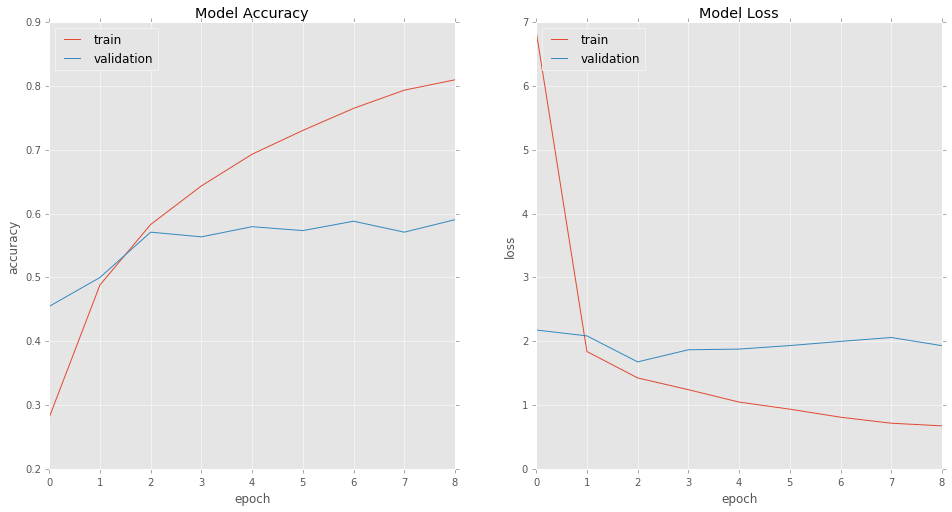

In [110]:
fig = plt.figure(figsize=(16,8))

print "History keys:", (history.history.keys())
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()